In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats.mstats import mquantiles
from scipy import stats

# Data Indexing and Reshaping 

In [22]:
with open('india_power_dataset.pkl', 'rb') as _file:
    load_, mapre_, capacity_ = pickle.load(_file)
    L_, time_                          = load_  
    s_Cap_, s_names_, w_Cap_, w_names_ = mapre_
    S_cf_, W_cf_                       = capacity_

S_cf_ = np.delete(S_cf_, [0, 4, 8, 12], axis = 2)
W_cf_ = np.delete(W_cf_, [0, 4, 8, 12], axis = 2)
print(S_cf_.shape, W_cf_.shape)

S_Cap_      = s_Cap_[:, np.newaxis]
W_Cap_      = w_Cap_[:, np.newaxis]

(566, 8760, 14) (311, 8760, 14)


In [23]:
#seasons
idx_days_ = np.arange(365, dtype = int)

spring_begin = 79
spring_end   = 169
idx_spring_  = ((idx_days_ >= spring_begin) & (idx_days_ < spring_end))
print(idx_spring_.sum())

summer_begin = 169
summer_end   = 261
idx_summer_  = ((idx_days_ >= summer_begin) & (idx_days_ < summer_end))
print(idx_summer_.sum())

fall_begin = 261
fall_end   = 352
idx_fall_  = ((idx_days_ >= fall_begin) & (idx_days_ < fall_end))
print(idx_fall_.sum())

winter_begin = 0
winter_end   = 79
winter_Begin = 352
winter_End   = 365
idx_winter_  = (((idx_days_ >= winter_begin) & (idx_days_ < winter_end)) | ((idx_days_ >= winter_Begin) & (idx_days_ <= winter_End)))
print(idx_winter_.shape)

90
92
91
(365,)


In [24]:
#Load Reshape
l_ = np.sum(L_ , axis = 1)[:, np.newaxis] # hourly energy demand in India
L = np.sum(l_, axis = 0) # total energy demand of India
L_reshape_ = L_.reshape(365, 24, 23) #
L_prime_ = np.sum(L_reshape_,axis = 2) 
L_days_ = np.sum( L_prime_, axis= 1)[:,np.newaxis]# L_(days,1)
print(L_days_.shape)

(365, 1)


# Solar Fraction and Overbuild 

In [88]:
r_s = .25
OB = 1.75
a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s,OB)

# Daily Analysis 


In [53]:
#seasonal Load 
L_w_ = L_prime_[idx_winter_, :]
L_spr_ = L_prime_[idx_spring_, :] 
L_smr_ = L_prime_[idx_summer_, :]
L_f_ = L_prime_[idx_fall_, :]
# Load stats 
l_w_med_, l_w_q_0_, l_w_q_25_, l_w_q_75_, l_w_q_100_            = _daily_stats(L_w_)
l_spr_med_, l_spr_q_0_ , l_spr_q_25_, l_spr_q_75_, l_spr_q_100_ = _daily_stats(L_spr_)
l_smr_med_, l_smr_q_0_ , l_smr_q_25_, l_smr_q_75_, l_smr_q_100_ = _daily_stats(L_smr_)
l_f_med_, l_f_q_0_ , l_f_q_25_, l_f_q_75_, l_f_q_100_           = _daily_stats(L_f_)
print(L_w_.shape)

(92, 24)


In [54]:
r_s_ = np.array([0., 0.25, 0.5, 0.75, 1.])
OB_  = np.array([1.,1.25,1.5,1.75,2])
print(r_s_.size,OB_.size)
E_balance_ = np.zeros((14,4))
scalar = []
fraction = []
for i in range(OB_.size):
    for j in range(r_s_.size):
        a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s_[j],OB_[i])
        scalar.append((a_hat_s, a_hat_w))
        fraction.append((OB_[i],r_s_[j]))


5 5


In [32]:
scalar_= np.array(scalar)
print(scalar_[1][1])
per_tot_year_ = np.zeros((r_s_.size*OB_.size,14,4))

for i in range(r_s_.size*OB_.size):
    for j in range(0,14):
        per_tot_year_[i] = _hourly_reliability(S_cf_, W_cf_,L_prime_, S_Cap_, W_Cap_, scalar_[i][1], scalar_[i][0], j)


0.4340729424468053


5.0


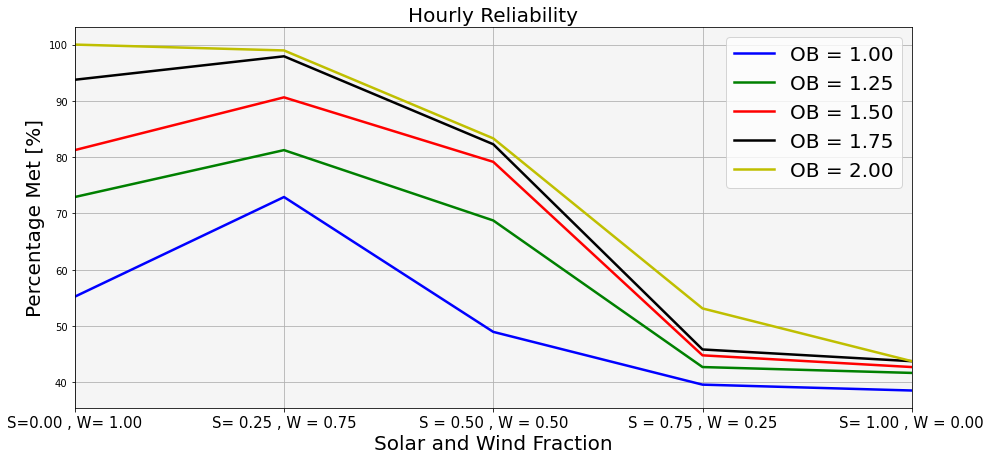

In [106]:
per_tot_= np.mean(np.mean(per_tot_year_,axis=2),axis=1)
i = (r_s_.size*OB_.size) / OB_.size
print(i)
per_tot_0_ = per_tot_[0:5]
per_tot_25_ = per_tot_[5:10]
per_tot_50_ = per_tot_[10:15]
per_tot_75_ = per_tot_[15:20]
per_tot_1_ = per_tot_[20:25]

plt.figure(figsize = (15, 7))
plt.gca().set_facecolor('whitesmoke')

plt.title('Hourly Reliability',fontsize=20) 
plt.plot(r_s_,per_tot_0_, 'b',linewidth=2.5, label =  'OB = ' +"{:.2f}".format(OB_[0]))
plt.plot(r_s_,per_tot_25_, 'g',linewidth=2.5, label =  'OB = ' +"{:.2f}".format(OB_[1]))
plt.plot(r_s_,per_tot_50_, 'r',linewidth=2.5, label =  'OB = ' +"{:.2f}".format(OB_[2]))
plt.plot(r_s_,per_tot_75_, 'k',linewidth=2.5, label =  'OB = ' +"{:.2f}".format(OB_[3]))
plt.plot(r_s_,per_tot_1_, 'y',linewidth=2.5, label =  'OB = ' +"{:.2f}".format(OB_[4]))




plt.legend(loc ='upper right' ,fontsize = 20.)

plt.xticks(r_s_,['S=' + "{:.2f}".format(r_s_[0]) + ' , W= '+  "{:.2f}".format(1-r_s_[0]),
                 'S= ' + "{:.2f}".format(r_s_[1]) + ' , W = '+  "{:.2f}".format(1-r_s_[1]),
                 'S = ' + "{:.2f}".format(r_s_[2]) + ' , W = '+  "{:.2f}".format(1-r_s_[2]),
                 'S = ' + "{:.2f}".format(r_s_[3]) + ' , W = '+  "{:.2f}".format(1-r_s_[3]),
                 'S= ' + "{:.2f}".format(r_s_[4]) + ' , W = '+  "{:.2f}".format(1-r_s_[4])],rotation = 0, fontsize=15)
plt.xlim(r_s_[0],r_s_[4])
plt.xlabel('Solar and Wind Fraction', fontsize=20) 
#plt.ylim(30,100)
plt.ylabel('Percentage Met [%]',fontsize=20)
plt.grid()
plt.savefig('/Users/dlopez/Desktop/india_power/Images/' + 'Hourly Reliability.png')
plt.show()

In [91]:

#Finding reliability percentage 
E_balance_ = np.zeros((14,4))
for i in range(0,14):
    E_balance_[i] = _hourly_reliability(S_cf_, W_cf_,L_prime_, S_Cap_, W_Cap_, a_hat_w, a_hat_s, i)
e_balance_ = np.mean(E_balance_, axis = 0)
print(e_balance_)

# average seasonal daily generation 
S_gen_w_= np.zeros((14,92,24))
S_gen_spr_= np.zeros((14,90,24))
S_gen_smr_= np.zeros((14,92,24))
S_gen_f_= np.zeros((14,91,24))
for i in range(0,14):
    S_gen_w_[i],S_gen_spr_[i], S_gen_smr_[i],S_gen_f_[i]=  hourly_solar_average(S_cf_,S_Cap_,a_hat_s, i)
S_w_avg_   = np.mean(S_gen_w_,axis=0)
S_spr_avg_ = np.mean(S_gen_spr_,axis=0)
S_smr_avg_ = np.mean(S_gen_smr_,axis=0)
S_f_avg_   = np.mean(S_gen_f_,axis=0)

W_gen_w_= np.zeros((14,92,24))
W_gen_spr_= np.zeros((14,90,24))
W_gen_smr_= np.zeros((14,92,24))
W_gen_f_= np.zeros((14,91,24))
for i in range(0,14):
    W_gen_w_[i],W_gen_spr_[i], W_gen_smr_[i],W_gen_f_[i]=  hourly_wind_average(W_cf_,W_Cap_,a_hat_w, i)
W_w_avg_   = np.mean(W_gen_w_,axis=0)
W_spr_avg_ = np.mean(W_gen_spr_,axis=0)
W_smr_avg_ = np.mean(W_gen_smr_,axis=0)
W_f_avg_   = np.mean(W_gen_f_,axis=0)

#season stats
S_w_med_, S_w_q_0_ , S_w_q_25_, S_w_q_75_, S_w_q_100_           = _daily_stats(S_w_avg_) 
S_spr_med_, S_spr_q_0_ , S_spr_q_25_, S_spr_q_75_, S_spr_q_100_ = _daily_stats(S_spr_avg_)
S_smr_med_, S_smr_q_0_ , S_smr_q_25_, S_smr_q_75_, S_smr_q_100_ = _daily_stats(S_smr_avg_)
S_f_med_, S_f_q_0_ , S_f_q_25_, S_f_q_75_, S_f_q_100_           = _daily_stats(S_f_avg_)  

W_w_med_, W_w_q_0_ , W_w_q_25_, W_w_q_75_, W_w_q_100_           = _daily_stats(W_w_avg_) 
W_spr_med_, W_spr_q_0_ , W_spr_q_25_, W_spr_q_75_, W_spr_q_100_ = _daily_stats(W_spr_avg_)
W_smr_med_, W_smr_q_0_ , W_smr_q_25_, W_smr_q_75_, W_smr_q_100_ = _daily_stats(W_smr_avg_)
W_f_med_, W_f_q_0_ , W_f_q_25_, W_f_q_75_, W_f_q_100_           = _daily_stats(W_f_avg_)  



[ 84.22619048 100.         100.          61.60714286]


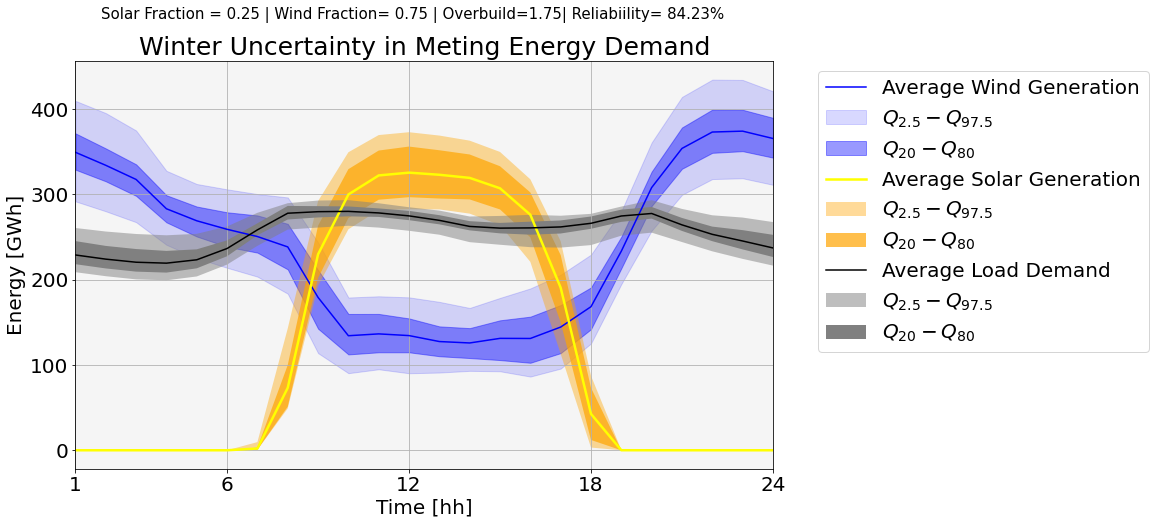

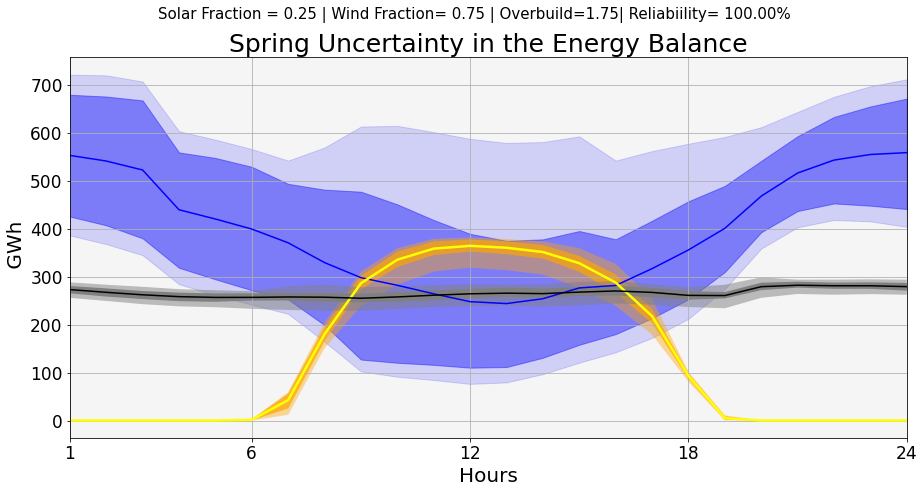

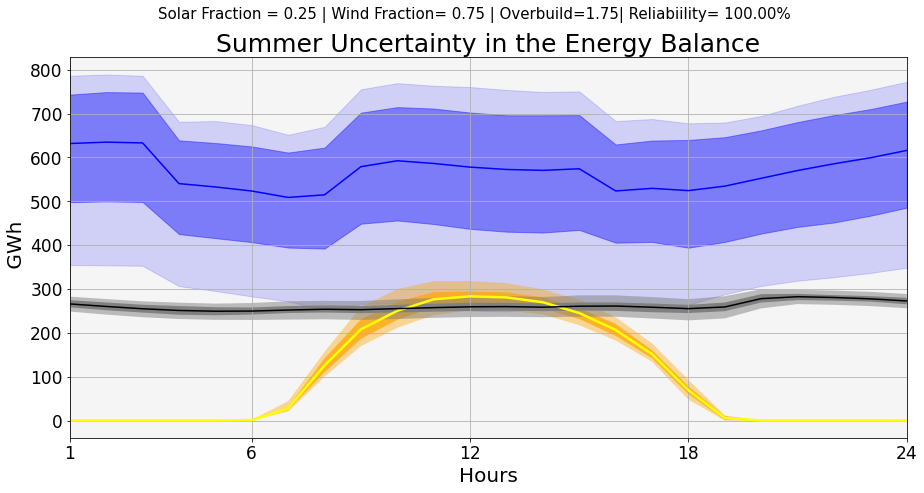

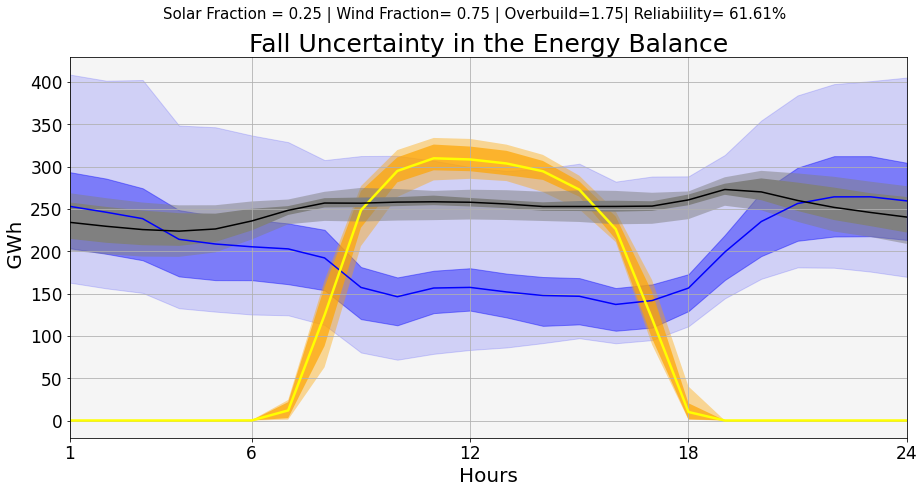

In [105]:
# winter
x_ = np.arange(0,24,1, dtype = int)
plt.figure(figsize = (12.5, 7.5))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_w_med_/1000, 'b', label = 'Average Wind Generation',)
plt.fill_between(x_, W_w_q_0_[:, 0]/1000., W_w_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, W_w_q_25_[:, 0]/1000., W_w_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_w_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_w_q_0_[:, 0]/1000., S_w_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_w_q_25_[:, 0]/1000., S_w_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_w_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_w_q_0_[:, 0]/1000., l_w_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, l_w_q_25_[:, 0]/1000., l_w_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{20}-Q_{80}$')

plt.title('Winter Uncertainty in Meting Energy Demand', fontsize= 25, loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB)+ '| Reliabiility= ' +  "{:.2f}".format(e_balance_[0])+'%', ha = 'center', va = 'top',fontsize=15.)


plt.xlabel('Time [hh]', fontsize = 20)
plt.ylabel('Energy [GWh]', fontsize = 20 )

plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 20)
plt.yticks(fontsize = 20.)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc ='upper left' ,fontsize = 20.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/' + 'Winter'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+ "{:.1f}.png".format(OB), dpi='figure', format='pdf')



plt.grid()
plt.show()

# spring
plt.figure(figsize = (15, 7))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_spr_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_spr_q_0_[:, 0]/1000., W_spr_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_spr_q_25_[:, 0]/1000., W_spr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_spr_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_spr_q_0_[:, 0]/1000., S_spr_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_spr_q_25_[:, 0]/1000., S_spr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_spr_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_spr_q_0_[:, 0]/1000., l_spr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, l_spr_q_25_[:, 0]/1000., l_spr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Spring Uncertainty in the Energy Balance', fontsize= 25, loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB)+ '| Reliabiility= ' +  "{:.2f}".format(e_balance_[1])+'%', ha = 'center', va = 'top',fontsize=15.)

plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 17.)
plt.yticks(fontsize = 17.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 17.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+ '_Spring'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.1f}.png".format(OB), dpi='figure', format='pdf')
plt.grid()
plt.show()

#summer
plt.figure(figsize = (15, 7))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_smr_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_smr_q_0_[:, 0]/1000., W_smr_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_smr_q_25_[:, 0]/1000., W_smr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, S_smr_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_smr_q_0_[:, 0]/1000., S_smr_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_smr_q_25_[:, 0]/1000., S_smr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_smr_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_smr_q_0_[:, 0]/1000., l_smr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_smr_q_25_[:, 0]/1000., l_smr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Summer Uncertainty in the Energy Balance', fontsize= 25,loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB)+ '| Reliabiility= ' +  "{:.2f}".format(e_balance_[2])+'%', ha = 'center', va = 'top',fontsize=15.)


plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 17.)
plt.yticks(fontsize = 17.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 17.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+ '_Summer'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.1f}.png".format(OB), dpi='figure' )

plt.grid()
plt.show()

# fall
plt.figure(figsize = (15, 7))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_f_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_f_q_0_[:, 0]/1000., W_f_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_f_q_25_[:, 0]/1000., W_f_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, S_f_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_f_q_0_[:, 0]/1000., S_f_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_f_q_25_[:, 0]/1000., S_f_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_f_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_f_q_0_[:, 0]/1000., l_f_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_f_q_25_[:, 0]/1000., l_f_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Fall Uncertainty in the Energy Balance', fontsize= 25,loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB)+ '| Reliabiility= ' +  "{:.2f}".format(e_balance_[3])+'%', ha = 'center', va = 'top',fontsize=15.)


plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 17.)
plt.yticks(fontsize = 17.)

plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+ '_Fall'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.1f}.png".format(OB), dpi='figure',)

plt.grid()
plt.show()

# Ramp Rates

In [55]:
dt = 1
# Energy met reshaping 

E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
E_s_hour_   = np.sum(E_s_scaled_, axis= 0)

E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis]  * W_cf_
E_w_hour_   = np.sum(E_w_scaled_, axis= 0)
L_net_ = ( E_s_hour_ + E_w_hour_) - l_

Rr_dt1_ = np.diff(L_net_, n = dt, axis = 0)/dt
Rr_dt1_frac_ = (Rr_dt1_ / l_[dt:])*100.

rr_dt1_ = Rr_dt1_frac_[:24 - dt, :]
Rr_dt1_ = Rr_dt1_frac_[24 - dt:, :]

rr_dt1_prime_ = rr_dt1_.flatten()[np.newaxis, :]
Rr_dt1_prime_ = np.reshape(Rr_dt1_, (364, 24*14))

# Define Storage Vectors size of year days
idx_ = Rr_dt1_prime_ == 0.
print(idx_.sum())

m_pos_ = np.zeros((365, 1))
m_neg_ = np.zeros((365, 1))
Q_pos_ = np.zeros((365, 4))
Q_neg_ = np.zeros((365, 4))

#Ramp Rates for each year
for i in range(Rr_dt1_prime_.shape[0]):
    idx_pos_ = Rr_dt1_prime_[i, :] > 0.
    
    med_pos, q_pos_ = _hourly_stats(Rr_dt1_prime_[i, idx_pos_])
    med_neg, q_neg_ = _hourly_stats(Rr_dt1_prime_[i, ~idx_pos_])

    m_pos_[i + 1] = med_pos
    m_neg_[i + 1] = med_neg
    Q_pos_[i + 1] = q_pos_
    Q_neg_[i + 1] = q_neg_

q_0_pos_      = Q_pos_[:,0]
q_25_pos_     = Q_pos_[:,1]
q_75_pos_     = Q_pos_[:,2]
q_100_pos_    = Q_pos_[:,3]    
q_0_neg_      = Q_neg_[:,0]
q_25_neg_     = Q_neg_[:,1]
q_75_neg_     = Q_neg_[:,2]
q_100_neg_    = Q_neg_[:,3]   
print(q_100_pos_.shape,m_neg_.shape,Q_pos_.shape,Q_neg_.shape)

0
(365,) (365, 1) (365, 4) (365, 4)


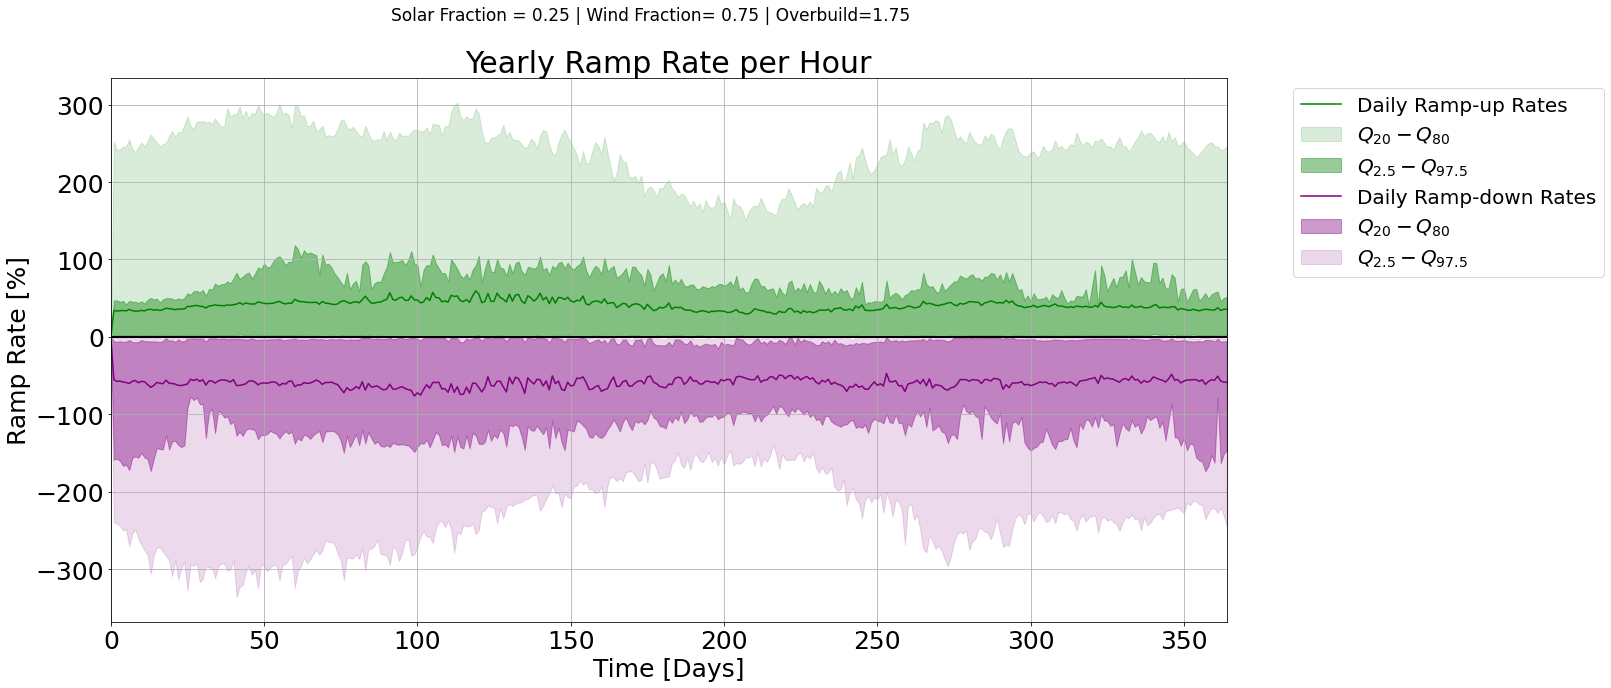

In [58]:
y_ =  np.arange(365, dtype = int)

plt.figure(figsize = (20, 10))

plt.plot(m_pos_, c = 'green', label = 'Daily Ramp-up Rates')
plt.fill_between(y_,q_100_pos_,q_0_pos_, alpha = 0.15,  edgecolor = 'green', facecolor = 'green', label = '$Q_{20}-Q_{80}$')
plt.fill_between(y_,q_75_pos_,q_25_pos_, alpha = 0.4,  edgecolor = 'green', facecolor = 'green', label = '$Q_{2.5}-Q_{97.5}$')

plt.plot(m_neg_, c = 'purple', label = 'Daily Ramp-down Rates')
plt.fill_between(y_,q_25_neg_,q_75_neg_, alpha = 0.4,  edgecolor = 'purple', facecolor = 'purple', label = '$Q_{20}-Q_{80}$')
plt.fill_between(y_,q_100_neg_,q_0_neg_, alpha = 0.15,  edgecolor = 'purple', facecolor = 'purple', label = '$Q_{2.5}-Q_{97.5}$')

plt.plot(np.repeat([0],365),'k',linewidth =2)

plt.title('Yearly Ramp Rate per Hour',fontsize=30)
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=17.)

plt.xlabel('Time [Days]', fontsize = 25)
plt.ylabel('Ramp Rate [%]', fontsize = 25 )
plt.xticks( fontsize=25)
plt.yticks( fontsize=25)
plt.xlim([0, 364])

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 20.)

plt.grid()
plt.show()

# Yearly Analysis 

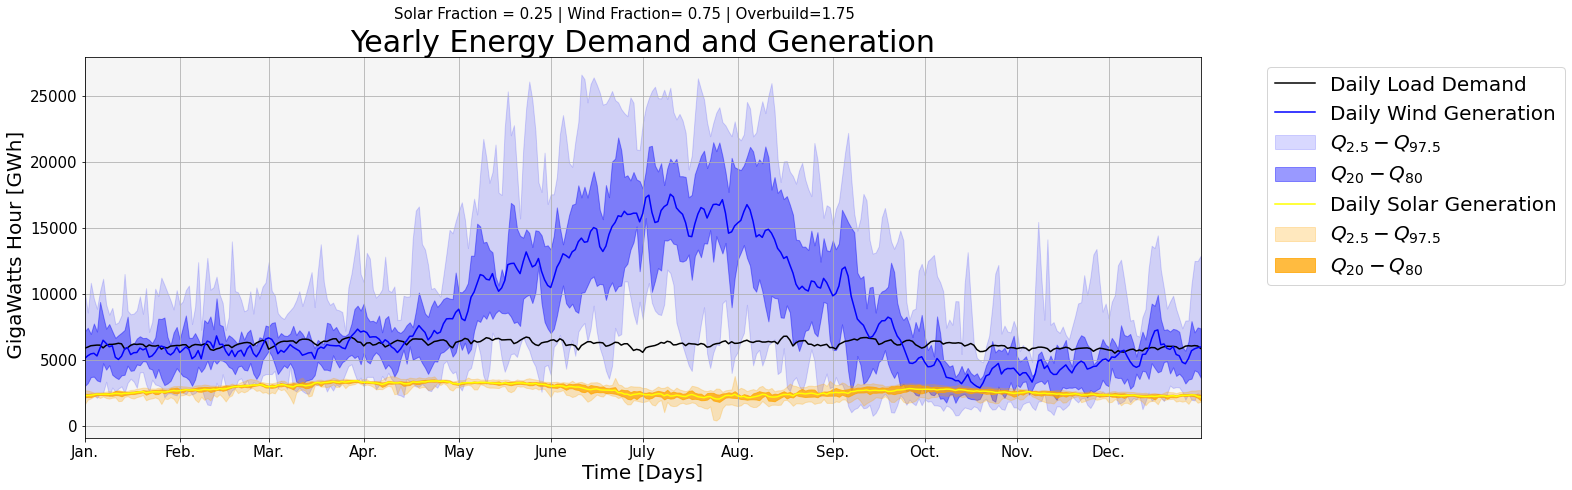

In [104]:

# Yearly Wind gen Scale 
E_w_scaled_a_ =  a_hat_w * W_Cap_[:,:,np.newaxis] * W_cf_
E_w_hour_a_ = np.sum(E_w_scaled_a_, axis= 0)
E_w_reshape_a_ = E_w_hour_a_.reshape(365,24,14)
E_w_days_a_ = np.sum(E_w_reshape_a_,axis=1)

E_s_scaled_a_ =  a_hat_s * S_Cap_[:,:,np.newaxis] * S_cf_
E_s_hour_a_ = np.sum(E_s_scaled_a_, axis= 0)
E_s_reshape_a_ = E_s_hour_a_.reshape(365,24,14)
E_s_days_a_ = np.sum(E_s_reshape_a_,axis=1)

y_ =  np.arange(365, dtype = int)
year_ = np.array([0,31,60,91,122,152,182,213,244,274,304,334])
months_ = np.array(['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.','Sep.','Oct.','Nov.','Dec.'])
#3
S_med_a_, S_q_0_a_ , S_q_25_a_, S_q_75_a_, S_q_100_a_  = year_stats(E_s_days_a_)
W_med_a_, W_q_0_a_ , W_q_25_a_, W_q_75_a_, W_q_100_a_  = year_stats(E_w_days_a_)


plt.figure(figsize = (20, 7))
plt.grid()
plt.gca().set_facecolor('whitesmoke')

plt.title('Yearly Energy Demand and Generation',fontsize = 30,loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=15.)


plt.xlabel('Time [Days]', fontsize = 20)
plt.ylabel(' GigaWatts Hour [GWh]', fontsize = 20 )

plt.plot(y_, L_days_/1000, 'k', label = 'Daily Load Demand')

plt.plot(y_,W_med_a_/1000, 'b', label = 'Daily Wind Generation')
plt.fill_between(y_, W_q_0_a_[:, 0]/1000., W_q_100_a_[:, 0]/1000., alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(y_, W_q_25_a_[:, 0]/1000., W_q_75_a_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(y_, S_med_a_/1000, 'yellow', label = 'Daily Solar Generation')
plt.fill_between(y_, S_q_0_a_[:, 0]/1000., S_q_100_a_[:, 0]/1000., alpha = .25,  edgecolor = 'orange', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(y_, S_q_25_a_[:, 0]/1000., S_q_75_a_[:, 0]/1000., alpha = 0.75,  edgecolor = 'orange', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.xticks(year_,months_,fontsize = 15.)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 20.)
plt.yticks(fontsize=15.)
plt.xlim([0, 364])

plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+ 'Yearly'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.1f}.png".format(OB), dpi='figure',)
plt.show()

# Battery Storage

In [84]:
E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
E_s_hour_   = np.sum(E_s_scaled_, axis= 0)

E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis]  * W_cf_
E_w_hour_   = np.sum(E_w_scaled_, axis= 0)
L_net_ = ( E_s_hour_ + E_w_hour_) - l_
L_net_prime_ = np.mean(L_net_,axis=1)
print(L_net_.shape)

(8760, 14)


In [87]:
Cap =  .5 * (np.sum(E_s_hour_ + E_w_hour_))
print(Cap)
soc = 0 
for i in range(0,8760):
    if L_net_prime_[i] > 0: 
        #Charging 
        if soc < Cap :
            soc = soc + L_net_prime_[i]
        else :
            print('Full')

    else :
        #Discharge
        if abs(L_net_prime_[i])> soc:
            L_net_prime_[i] = L_net_prime_[i] - soc
        else :
            L_net_prime_[i] = 0 
print(np.sum(L_net_prime_),np.sum(L_net_))


31652936104.684982
3460280321.401732 31666235859.369953


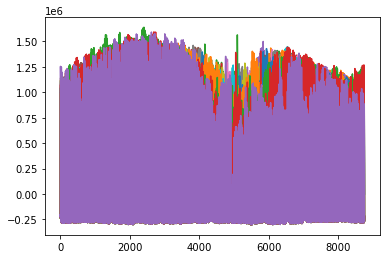

In [86]:
plt.figure()
plt.plot(L_net_prime_)
plt.plot(L_net_)
plt.show()

# Functions

In [29]:

def _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB):
    r_w = 1 - r_s
    #1
    s_Cap_prime_ = np.repeat(s_Cap_[..., np.newaxis], 8760, axis = 1)
    s_Cap_prime_ = np.repeat(s_Cap_prime_[..., np.newaxis], 14, axis = 2)
    w_Cap_prime_ = np.repeat(w_Cap_[..., np.newaxis], 8760, axis = 1)
    w_Cap_prime_ = np.repeat(w_Cap_prime_[..., np.newaxis], 14, axis = 2)

    E_s_pot_year_ = s_Cap_prime_ * S_cf_
    E_w_pot_year_ = w_Cap_prime_ * W_cf_
    #2
    e_s_tot_years_ = np.sum(np.sum(E_s_pot_year_, axis = 0), axis = 0)[:, np.newaxis]
    e_w_tot_years_ = np.sum(np.sum(E_w_pot_year_, axis = 0), axis = 0)[:, np.newaxis]
    #3 
    beta_s_ = L/e_s_tot_years_
    beta_hat_s = np.mean(beta_s_) 
    beta_w_ = L/e_w_tot_years_
    beta_hat_w = np.mean(beta_w_) 
    
    #4 solar 
    a_s_avg = r_s * beta_hat_s * OB
    a_w_avg = r_w * beta_hat_w * OB

    return a_s_avg , a_w_avg, beta_s_, beta_w_

def _resiliance(E_s_hour_,E_w_hour_, l_, a_hat_s, a_hat_w):
    
    E_net_ = (E_s_hour_ + E_w_hour_) - l_
    
    E_net_daily_ = np.sum(np.reshape(E_net_,(365,24,14)), axis=1)
    L_net_daily_ = np.sum(np.reshape(l_,(365,24,1)), axis=1)
    
    R_ = 100 * (E_net_daily_ / L_net_daily_) + 100
    
    return R_

def year_stats(Data_):  
    # Median
    med_      = np.mean(Data_, axis = 1)
    # Quantile Statistics
    quantiles = stats.mstats.mquantiles(Data_, [0., 0.25, 0.75, 1.], axis = 1)
    q_0_      = quantiles[:,0]
    q_25_     = quantiles[:,1]
    q_75_     = quantiles[:,2]
    q_100_    = quantiles[:,3]
    return med_[:, np.newaxis], q_0_[:, np.newaxis], q_25_[:, np.newaxis], q_75_[:, np.newaxis], q_100_[:, np.newaxis]

def _daily_stats(Data_):  
    # Median
    med_      = np.mean(Data_, axis = 0)
    # Quantile Statistics
    quantiles = stats.mstats.mquantiles(Data_, [0.025, 0.2, 0.8, .975], axis = 0)
    q_0_      = quantiles[0, :]
    q_25_     = quantiles[1, :]
    q_75_     = quantiles[2, :]
    q_100_    = quantiles[3, :]
    return med_[:, np.newaxis], q_0_[:, np.newaxis], q_25_[:, np.newaxis], q_75_[:, np.newaxis], q_100_[:, np.newaxis]

def _hourly_stats(data_):  
    #Quantile Statistics
    m  = np.mean(data_)
    q_ = stats.mstats.mquantiles(data_, [0.025, .2 ,0.8, .975])
    return m, q_

# Averages 1 years data to generate percentage of demand met for each season
def _hourly_reliability(S_cf_, W_cf_,L_prime_, S_Cap_, W_Cap_, a_hat_w, a_hat_s, y):
    S_cf_prime_ = S_cf_[:, :, y]
    W_cf_prime_ = W_cf_[:, :, y]
    e_s_ = np.sum(S_Cap_ * S_cf_prime_ , axis = 0)[:, np.newaxis]
    e_w_ = np.sum(W_Cap_ *W_cf_prime_, axis = 0)[:, np.newaxis]

    e_tot_ =  (e_w_ * a_hat_w) + (e_s_ * a_hat_s)
    E_tot_ = np.reshape(e_tot_,(365,24))
    # tottal energy season indexing 
    E_w_tot_  = E_tot_[idx_winter_, :]
    E_w_tot_  = np.mean(E_w_tot_, axis=0)

    E_spr_tot  = E_tot_[idx_spring_, :]
    E_spr_tot_  = np.mean(E_spr_tot, axis=0)

    E_smr_tot_ = E_tot_[idx_summer_, :]
    E_smr_tot_  = np.mean(E_smr_tot_, axis=0)

    E_f_tot_ = E_tot_[idx_fall_, :]
    E_f_tot_  = np.mean(E_f_tot_, axis=0)

    #Load season indexing 
    L_w_ = L_prime_[idx_winter_, :]
    L_w_  = np.mean(L_w_, axis=0)

    L_spr_ = L_prime_[idx_spring_, :] 
    L_spr_  = np.mean(L_spr_, axis=0)

    L_smr_ = L_prime_[idx_summer_, :]
    L_smr_  = np.mean(L_smr_, axis=0)

    L_f_ = L_prime_[idx_fall_, :]
    L_f_  = np.mean(L_f_, axis=0)

    w_rel = _percent_met(L_w_ ,E_w_tot_)
    spr_rel = _percent_met(L_spr_ ,E_spr_tot_)
    smr_rel = _percent_met(L_smr_ ,E_smr_tot_)
    f_rel = _percent_met(L_f_ ,E_f_tot_)
    return np.array([w_rel,spr_rel, smr_rel, f_rel])

# To find the average daily generation 
def hourly_solar_average(S_cf_, S_Cap_,a_hat_s, y):
    E_s_scaled_a_ =  a_hat_s * S_Cap_ * S_cf_[:, :, y] 
    E_s_hour_a_ = np.sum(E_s_scaled_a_, axis= 0) # (hours,years)
    E_s_prime_ = E_s_hour_a_.reshape(365,24)
    #solar 
    S_w_ = E_s_prime_[idx_winter_, :] 
    S_spr_ = E_s_prime_[idx_spring_, :] 
    S_smr_ = E_s_prime_[idx_summer_, :] 
    S_f_ = E_s_prime_[idx_fall_, :] 
    return S_w_, S_spr_, S_smr_, S_f_

def hourly_wind_average(W_cf_, W_Cap_,a_hat_s, y):
    E_w_scaled_a_ =  a_hat_s * W_Cap_ * W_cf_[:, :, y] 
    E_w_hour_a_ = np.sum(E_w_scaled_a_, axis= 0) # (hours,years)
    E_w_prime_ = E_w_hour_a_.reshape(365,24)
    #solar 
    W_w_ = E_w_prime_[idx_winter_, :] 
    W_spr_ = E_w_prime_[idx_spring_, :] 
    W_smr_ = E_w_prime_[idx_summer_, :] 
    W_f_ = E_w_prime_[idx_fall_, :] 
    return W_w_, W_spr_, W_smr_, W_f_



# Scrap 

0.0 1.0 1.0
0.0 0.578763923262407


/var/folders/99/fl4_sjvj2px9bv5z1fjz0w600000gn/T/ipykernel_1600/516580555.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar.get_ticks(), fontsize=15)


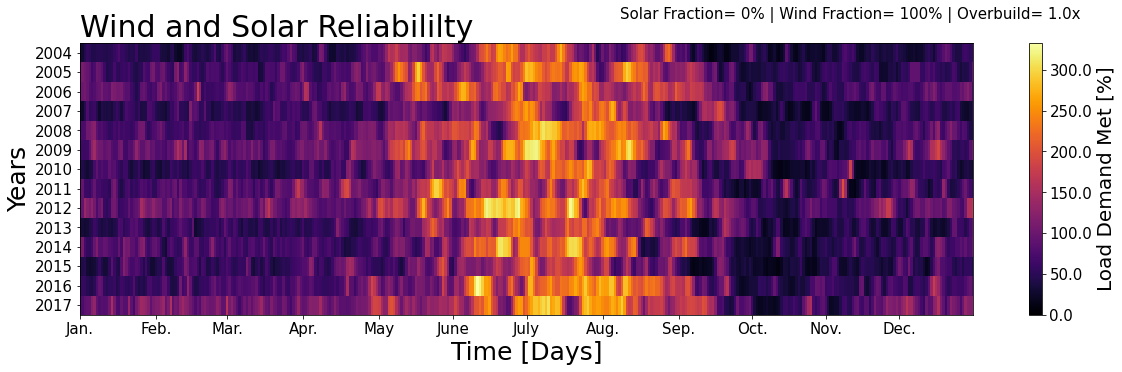

0.0 1.0 1.25
0.0 0.7234549040780087


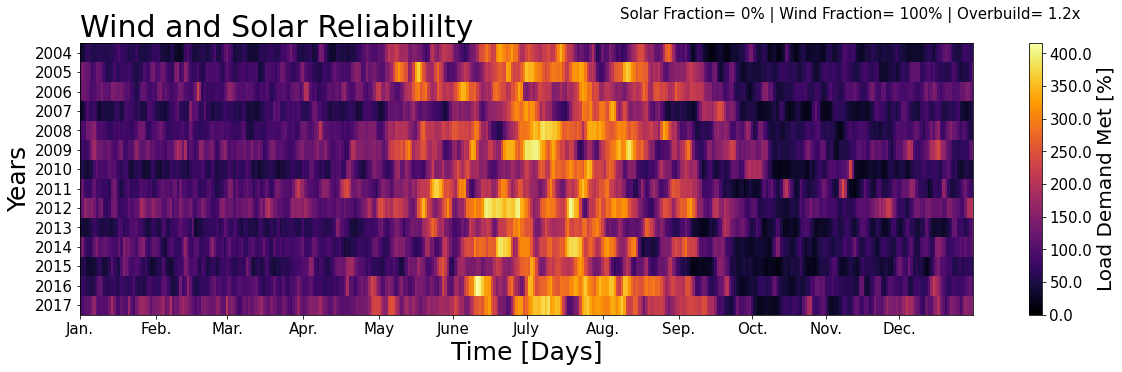

0.0 1.0 1.35
0.0 0.7813312964042495


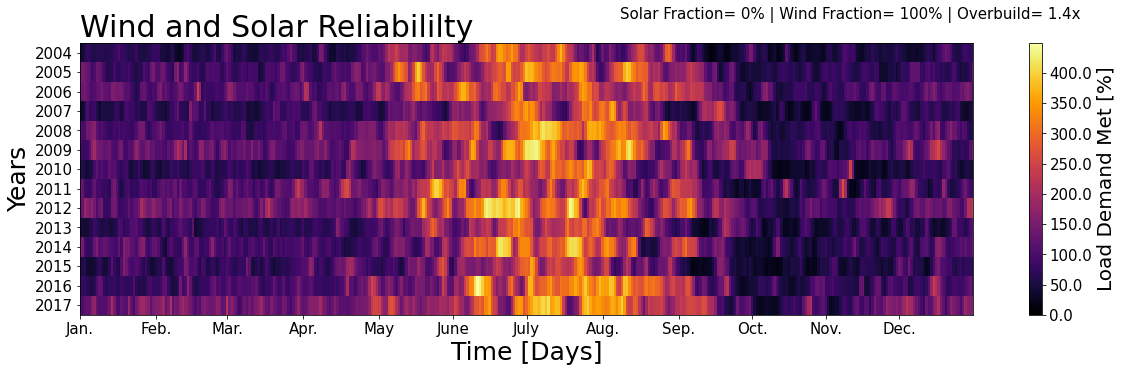

0.0 1.0 1.5
0.0 0.8681458848936106


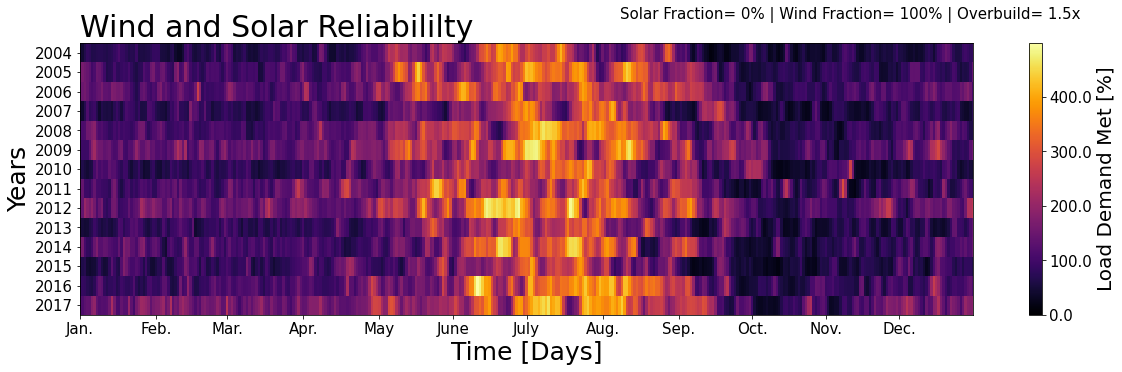

0.25 0.75 1.0
0.07147925920118788 0.4340729424468053


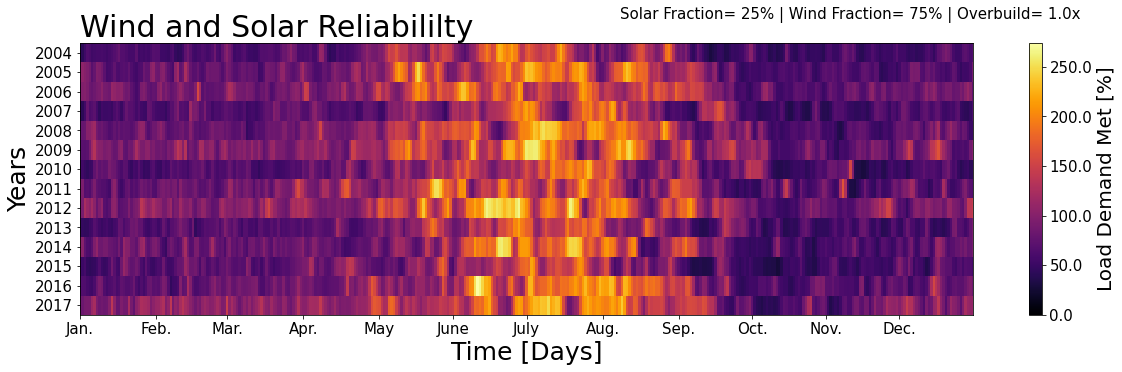

0.25 0.75 1.25
0.08934907400148484 0.5425911780585067


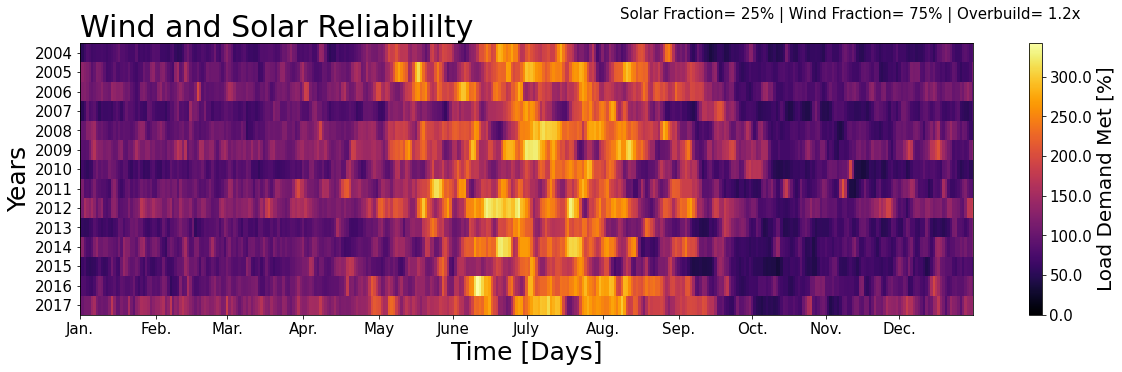

0.25 0.75 1.35
0.09649699992160364 0.5859984723031871


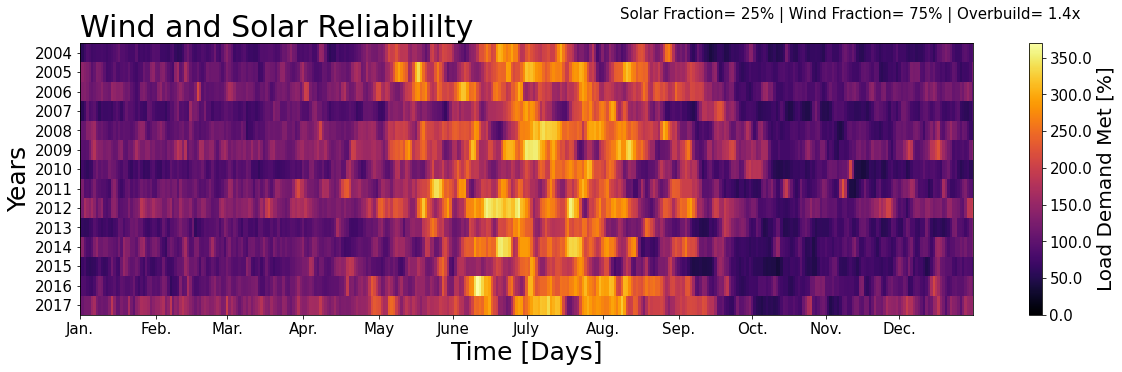

0.25 0.75 1.5
0.10721888880178182 0.6511094136702079


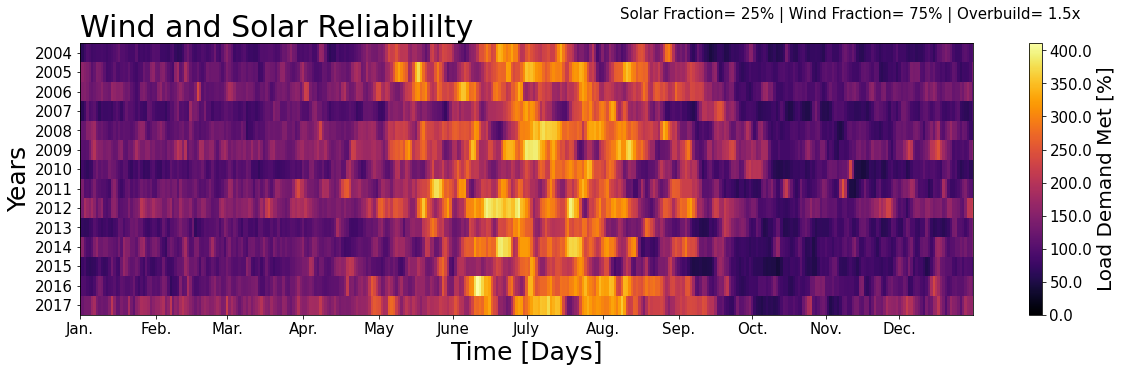

0.5 0.5 1.0
0.14295851840237575 0.2893819616312035


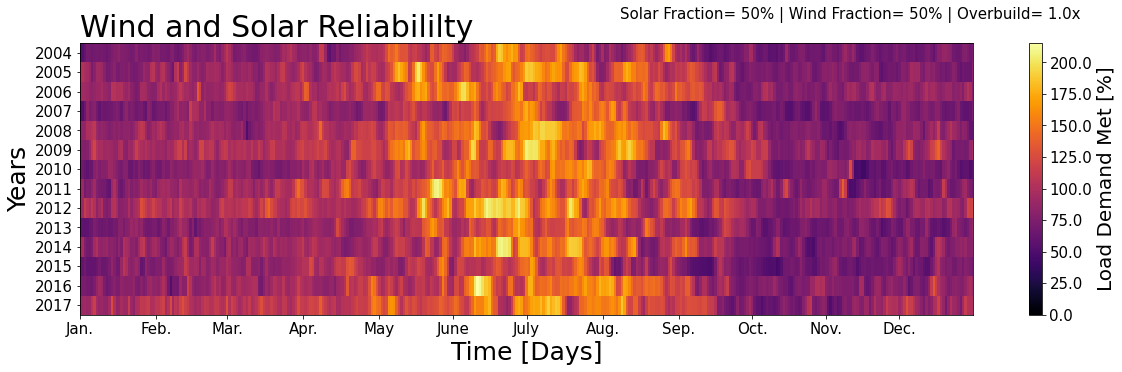

0.5 0.5 1.25
0.17869814800296968 0.36172745203900436


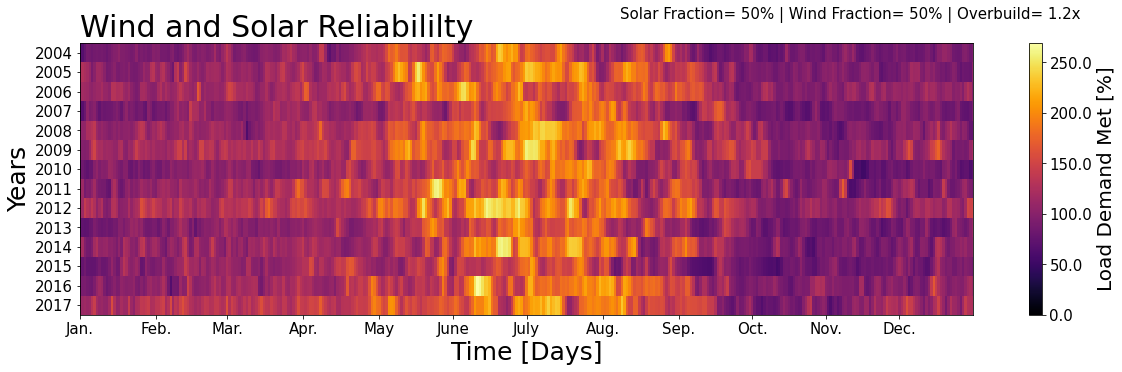

0.5 0.5 1.35
0.19299399984320728 0.39066564820212474


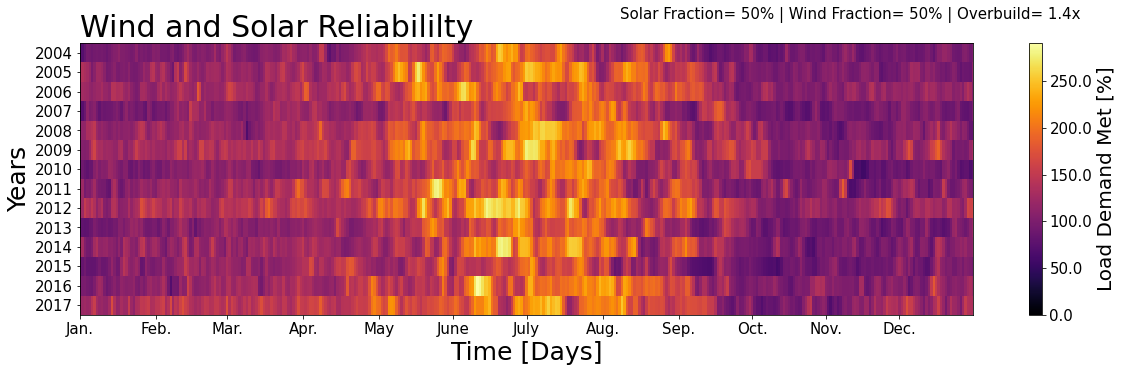

0.5 0.5 1.5
0.21443777760356364 0.4340729424468053


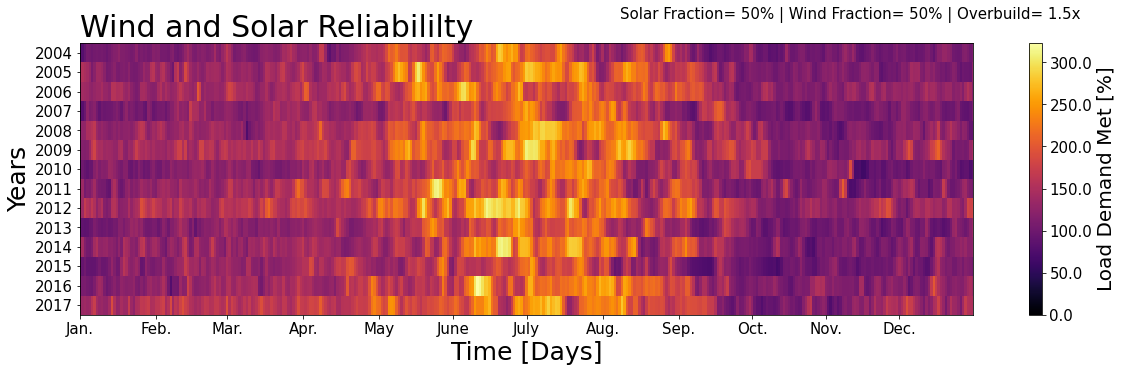

0.75 0.25 1.0
0.21443777760356364 0.14469098081560175


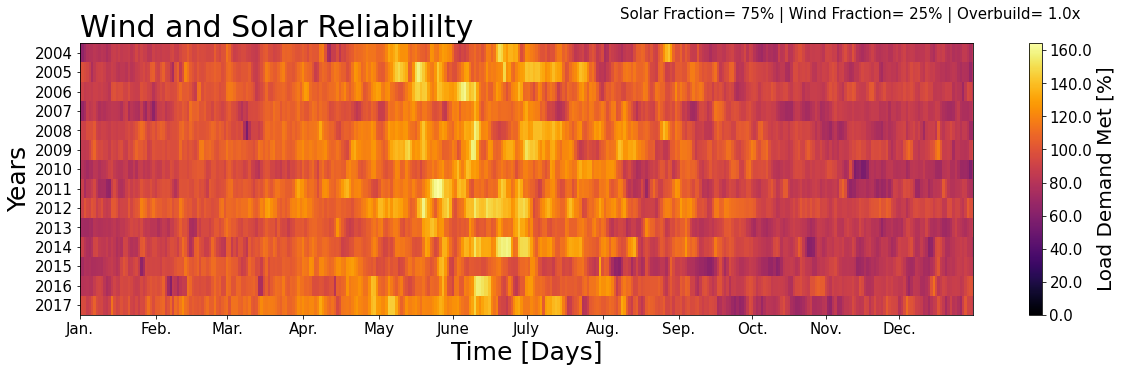

0.75 0.25 1.25
0.2680472220044545 0.18086372601950218


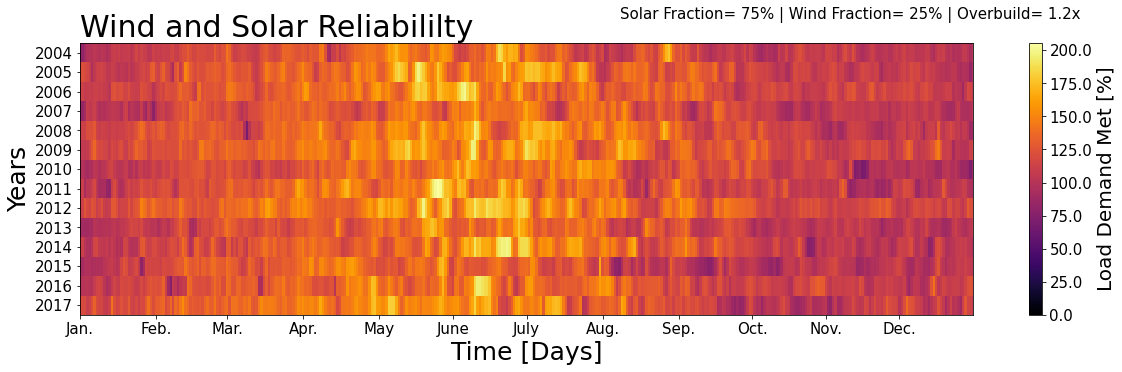

0.75 0.25 1.35
0.2894909997648109 0.19533282410106237


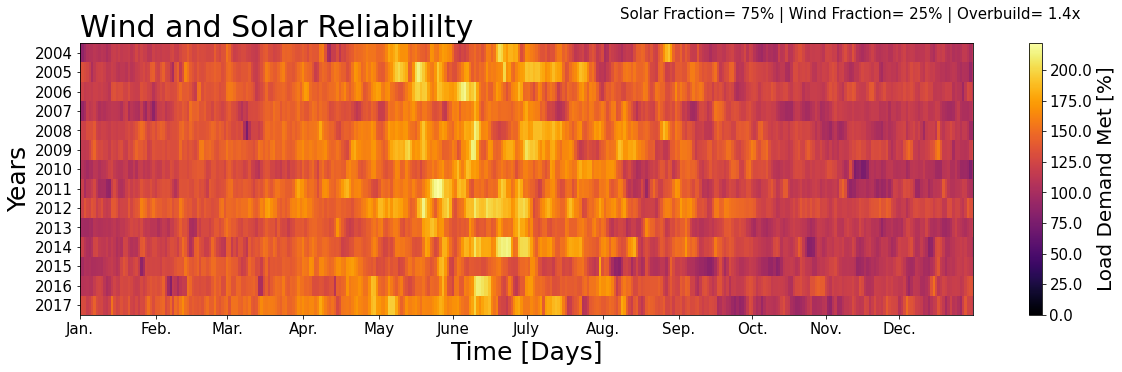

0.75 0.25 1.5
0.32165666640534546 0.21703647122340264


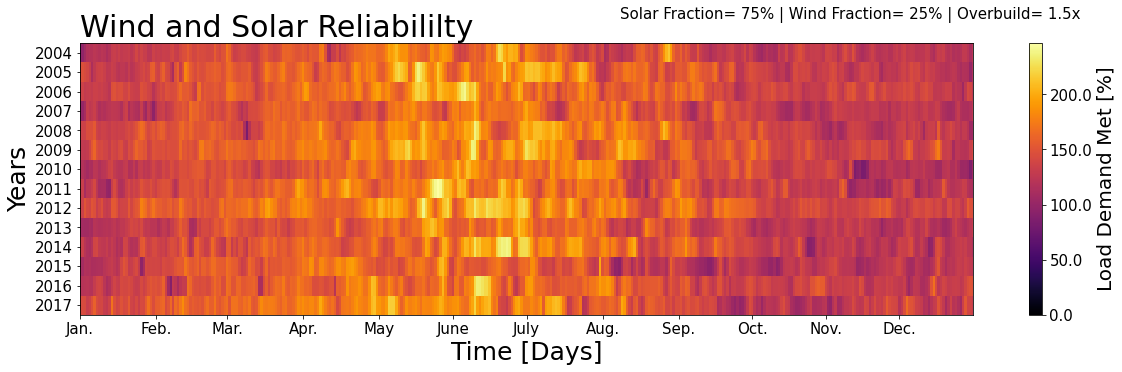

1.0 0.0 1.0
0.2859170368047515 0.0


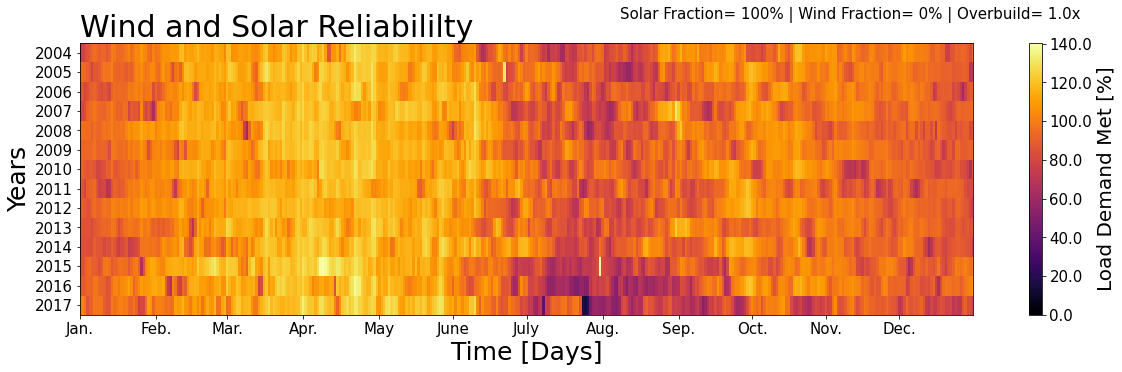

1.0 0.0 1.25
0.35739629600593936 0.0


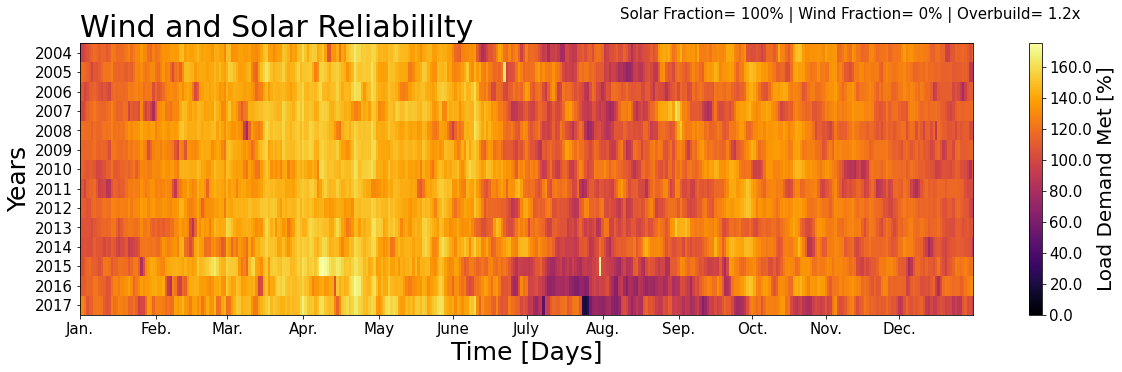

1.0 0.0 1.35
0.38598799968641456 0.0


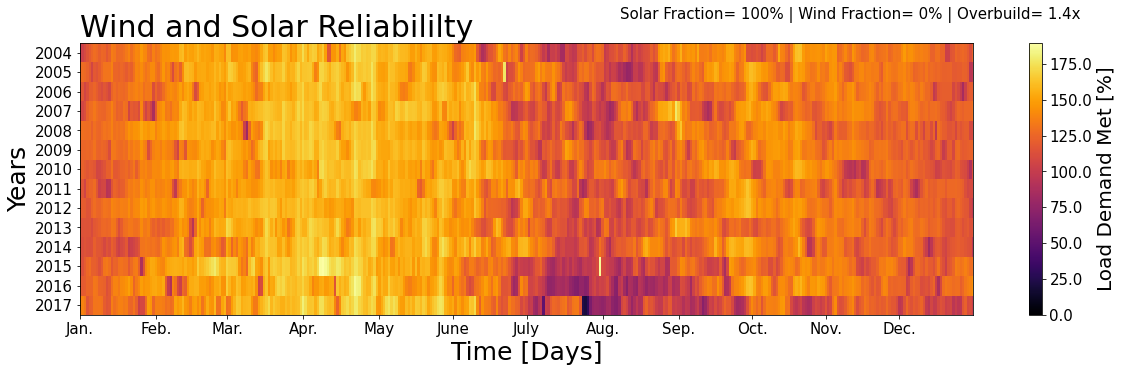

1.0 0.0 1.5
0.4288755552071273 0.0


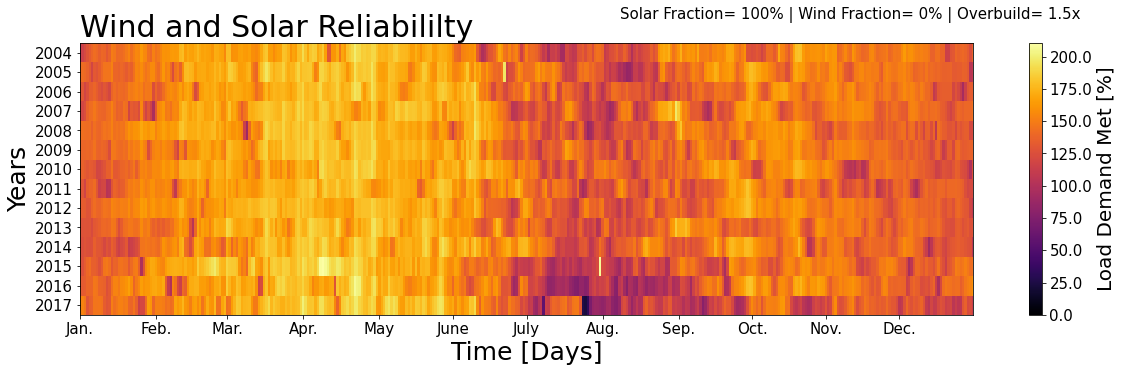

In [222]:
r_s_ = [0., 0.25, 0.5, 0.75, 1.]
OB_  = [1.,1.25, 1.35, 1.5]

for i in range(len(r_s_)):
    for j in range(len(OB_)):
        r_s = r_s_[i]
        r_w = 1 - r_s
        OB  = OB_[j]
        print(r_s, r_w, OB)
        
        a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)
        print(a_hat_s, a_hat_w)

        N_per_ =  _resiliance(E_s_hour_,E_w_hour_, l_, a_hat_s, a_hat_w)
      
        plt.figure(figsize = (20, 5))
        plt.title('Wind and Solar Reliabililty',fontsize = 30, loc = 'left')
        plt.suptitle(r'Solar Fraction= {}%'.format(int(r_s*100)) + ' | Wind Fraction= {}%'.format(int(r_w*100)) + ' | Overbuild= {:.1f}x'.format(OB), ha = 'left', va = 'top',fontsize=15.)

        plt.xlabel('Time [Days]', fontsize = 25)
        plt.ylabel('Years', fontsize = 25 )

        plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', vmin = 0, cmap = 'inferno')

        plt.xticks(year_,months_, fontsize=15)
        plt.yticks(np.arange(0,14,1),np.arange(2004,2018,1), fontsize=15)
        plt.xlim([0, 364])

        
        cbar = plt.colorbar()
        cbar.set_ticklabels(cbar.get_ticks(), fontsize=15)
        cbar.set_label(label ='Load Demand Met [%]', fontsize=20)
        plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+  'Resiliance'+'_'+"{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+ "{:.1f}.png".format(OB), dpi = 'figure')
        plt.show()

 



        